In [55]:
import importlib
import torch
import numpy as np
import scipy.ndimage
from torch.autograd import Variable
import torch.nn.functional as F
from torch import optim, nn
from torchvision import datasets, models, transforms
from PIL import Image

from matplotlib import pyplot as plt
from utils import img, pyramid, stats, hooking

## Setting up the model

First, we download a pre-trained vgg19 model (as recommended in the paper).

In [56]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

vgg19 = models.vgg19(pretrained=True).to(device)
for param in vgg19.features.parameters(): # stop training the net
    param.requires_grad = False

Load the model onto your GPU (if you have one) and "freeze" it, preventing any additional gradient updates from occurring to the already trained model. 

**Note:** I'm freezing each set of parameters individually *after* loading the model into my GPU. This is because the process of loading into the GPU destroys the old parameter tensors and creates new ones on the GPU (so freezing beforehand would have no effect).

In [57]:
normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std
    
normalization_layer = Normalization(normalization_mean, normalization_std).to(device)

In [58]:
useful_layers = list(list(vgg19.children())[0][:13])
useful_layers.insert(0, nn.Sequential(normalization_layer))

vgg = nn.Sequential(*vgg_seq)
print(len(list(vgg.children())))
list(vgg.children())

14


[Normalization(),
 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]

Optionally, we can also replace all the max pool layers in our vgg network with average pool layers as suggested in the paper. Personally I found that this made gradient updates a bit trickier, but it did give nicer results once I got it working.

In [59]:
# vgg_layers = list(vgg.children())[0]

# for i in range(len(vgg_layers)):
#     if (vgg_layers[i].__class__.__name__ == "MaxPool2d"):
#         vgg_layers[i] = nn.AvgPool2d(2)

Lastly, we'll remove the fully connected layers from our pretained vgg network. We don't need these for texture synthesis, and leaving them in limits us to input images of size 224x224 only.

**Note:** `some_model.children()` returns an iterator containing all of the model's layers. Common practice is to turn this into a list in order to interact with it. With vgg19 what you'll actually get is a list containing two lists. The first of these contains all the layers we need.

## Perpairing the example texture

The pre-trained networks from torchvision.models need to be passed inputs in a certain format, so we're going to add a transform to apply those transformations to all the image's we're dealing with. We also define a helper function `image_loader` which takes a relative image path, loads the image into a tensor, applies the relevant transformations and returns it.

`show_image` makes it easier to view images we load using `image_loader`. Pytorch doesn't seem to have any good method for visualizing tensors, so we convert the tensor to a numpy array, transpose it and then plot that using matplotlib.

**Note:** `unsqueeze()` is a pytorch function that adds extra dimensions to tensors. We're using it here because vgg19 only takes mini-batches of images, and we're working with a single image. We use `.unsqueeze()` to add the extra dimension to our image tensor and trick vgg into thinking it's dealing with a small minibatch of images. 

**Note 2:** For classification vgg19 expects input images to be normalized according to imagenet mean values. The commented out line below applies this transform. We're not doing classification though and *should not* add it here. It would cause our sample textures to be optimized to look like the *normalized* version of the example texture (i.e. off color and weird). See `data/samples/stones-normalized` for what happened to me. We can also ignore the usual size constraint of 224x224 since convolutional layers are size-agonstic and we already removed all the fully connected layers.

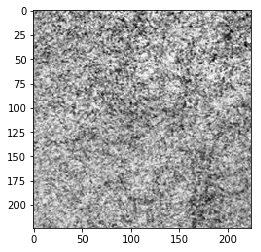

In [60]:
transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

img_path = "data/style/"
img_name = "don-kenn-6.jpg" # we use this variable later
full_path = img_path + img_name

style_img = img.image_loader(full_path, transform)
img.show_image(style_img)

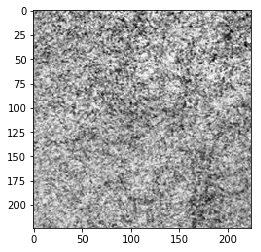

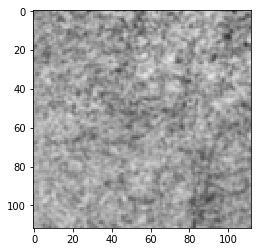

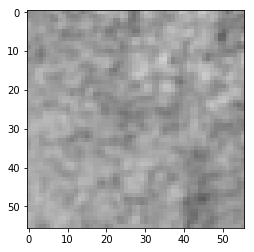

In [61]:
pyramid_height = 2
gaussian_kernel = pyramid.build_gauss_kernel(n_channels=3, cuda=True)

style_pyr = pyramid.gaussian_pyramid(style_img, gaussian_kernel, max_levels=pyramid_height)
for pyr_slice in style_pyr:
    img.show_image(pyr_slice)

The paper reccomends using the 3rd and 8th layers (only counting conv and pooling layers)

In [62]:
hooks = hooking.attach_hooks(vgg, [5, 13])
print(len(hooks)) # should be 2

style_feature_pyr = []

for pyr_slice in style_pyr:
    vgg(pyr_slice)
    slice_stats = [stats.gram_matrix(hook.features) for hook in hooks]
    style_feature_pyr.append(slice_stats)

2


In [63]:
# hooks = hooking.attach_hooks(vgg, [0, 2, 5, 7, 10])
# print(len(hooks)) # should be 2

# vgg(style_img)
# style_feature_pyr = [[stats.gram_matrix(hook.features) for hook in hooks]]

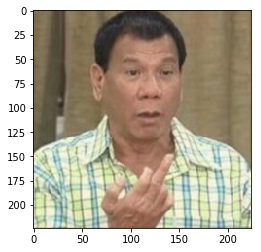

In [64]:
importlib.reload(img)
content_tfm = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

content_img_name = "duterte-4.jpeg" # we use this variable later
content_img_path = "data/content/"
full_content_path = content_img_path + content_img_name

content_img = img.image_loader(full_content_path, content_tfm)
img.show_image(content_img)

In [65]:
from PIL import Image
content_hook = hooking.attach_hooks(vgg, [7])[0]
with torch.no_grad():
    vgg(content_img)
    
content_features = content_hook.features
print(content_features.size())

torch.Size([1, 128, 112, 112])


## Computing Loss

Next we need a way of generating a loss from the example summary statistics (above), and some sample summary statistics (which we will eventually generate by passing the sample texture through our vgg network in exactly the same way). The paper recommends calculating the **mean squared error** loss between the two sets of gram matrices.

I had a lot of trouble with this. The losses were always tiny (probably because, as above, the gram matrices I calculated from the feature maps tended to hold super small values), and often resulted in outright 0 gradients. The hacky-as-balls solution I came up with was to literally just scale the loss by some factor before returning. Gross I know.

The paper also recommends using LBFGS to perform gradient updates. `torch.optim` provides a convenience [method](https://pytorch.org/docs/stable/optim.html) for this which you should probably look up. The main takeaway is: if you're using `torch.optim.LBFGS()` as your optimizer, you can't just call `optimizer.step()` like normal. Instead, you need to pass in a special `closure()` function that calculates and returns your loss. Because we can't pass any arguments to the `closure()` function directly, we're going to create a class (`GradientStepper`) around this `closure()` function and use attribute variables on that class as parameters to our `closure()`. 

We'll also add our loss function to this class for conveniance.

In [66]:
class GradientStepper():
    gaussian_kernel = pyramid.build_gauss_kernel(n_channels=3, cuda=True)
    
    def __init__(self, optimizer, model, sample, style_feature_pyr, hooks, scale, content_hook, target_features, max_levels):
        self.optimizer = optimizer
        self.sample = sample
        self.style_feature_pyr = style_feature_pyr
        self.model = model
        self.hooks = hooks
        self.scale = scale
        self.losses = []
        self.max_levels = max_levels
        
        self.content_hook = content_hook
        self.target_features = target_features

    def style_loss(self, sample_feature_pyr):
        loss = 0
        
        for i in range(len(sample_feature_pyr)):
            sample_stats = sample_feature_pyr[i]
            target_stats = self.style_feature_pyr[i]
            
            for j in range(len(sample_stats)):
                loss += F.mse_loss(sample_stats[j], target_stats[j])

        return loss * self.scale
    
    
    def content_loss(self, content_features):
        loss = F.mse_loss(content_features, self.target_features)
        return loss * 100
    
    def loss_fn(self, sample_feature_pyr, content_features):
        return self.style_loss(sample_feature_pyr) + self.content_loss(content_features)
    
    def gaussian_pyramid(self):
        return pyramid.gaussian_pyramid(self.sample, self.gaussian_kernel, max_levels=self.max_levels)
    
    def closure(self):
        self.optimizer.zero_grad() # Please read up on this if you don't know what it does. 
        
        self.model(self.sample)
        
        # sample style features
        sample_pyr = self.gaussian_pyramid()
        sample_feature_pyr = []
        
        for sample in sample_pyr:
            sample_feature_pyr.append([stats.gram_matrix(hook.features) for hook in self.hooks])
        
        # sample content features
        sample_content = self.content_hook.features
        
        loss = self.loss_fn(sample_feature_pyr, sample_content)
        self.losses.append(loss)
        loss.backward()

#         print("loss: {}".format(loss))

        return loss


## Create the Sample Texture

Nearly there. Now we need to create a random image that will eventually become out sample texture. We're going to pass this texture through our vgg network and keep performing gradient descent on it against the above loss function until its summary statistics more or less match the example texture.

We use numpy to create the random image here because numpy is generally better at operating on matrices. In particular we want to smoothen the image because real life images have a natural smoothness to them.


## Generate the Sample Texture

And here we are. Basically all we do now is perform an arbitrary number of gradient updates on the random sample texture. Once that's done it should look a bit like the example texture (hopefully). To make this clean and reusable, we're going to pack this process into a class called `Synthesizer`, which will take in a bunch of hyperparameters and also save the generated textures as `.jpg`'s for viewing later.

First though, we're going to define some conveniance functions.

### Viewing Images

Rather than displaying the generated images here in the notebook I'm saving them to directories in this workspace. This way we can examine them at them at our leisure later. In particular I want to save a bunch of images throughout the generation process so I can observe how it's going. I'm going to give each image an "identifier", which is basically just a string representation of the hyperparameters used to generate it.


In [67]:
def identifier(params):
    id = ""
    for key in params:
        if key not in ["hooks", "content_hook", "model", "iterations", "id", "image"]:
            id += "{}{}-".format(key, params[key])
        
    return id[:-1]

### Synthesizer

The only important method is `synthesize`, the rest of it is just there to save the sample textures to the right directories. Basically this method takes a bunch of hyperparameters, generates a (quasi) random image, and performs gradient updates on it for a given number of iterations using the `GradientStepper` class we defined earlier.

In [68]:
class Transferrer():
    def __init__(self, params):
        self.saver = img.Saver(params["save_mode"])
        self.style_feature_pyr = params["style_feature_pyr"]
        self.target_features = params["content_features"]
        self.save_at = 1 if params["save_mode"] == "throughout" else 0
    
    def transfer(self, params):
        if self.save_at == 0:
            self.save_at = params["iterations"]
        
        opt_img = params["image"]
        optimizer = optim.LBFGS([opt_img], lr=params["lr"])
        stepper = GradientStepper(
            optimizer, 
            params["model"], 
            opt_img, 
            self.style_feature_pyr, 
            params["hooks"], 
            params["scale"],
            params["content_hook"],
            self.target_features,
            params["max_levels"],
        )
        
        self.saver.prepair_save_directory(params)

        for i in range (params["iterations"]):
#             if opt_img.grad is not None:
#                 print(opt_img.grad[0][0][0][:4])

            optimizer.step(stepper.closure)

            # occationally save an image so see how generation is going
            if (i + 1) == self.save_at:
                self.saver.save_image(opt_img, self.save_at)
                self.save_at *= 2
        
        self.sate_at = 0
        return opt_img, stepper.losses

### Execution

Feel free to fiddle around with hyperparameters here, but I did a fair bit of fiddling myself, and to be honest  the only thing that seemed to make any real difference was the scale, which just needed to remain > 10,000.

In [ ]:
opt_tfm = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
])

opt_img = img.image_loader(full_content_path, opt_tfm, requires_grad=True)

params = {
    "image": opt_img,
    "style": img_name,
    "content": content_img_name,
    "size": 224,
    "iterations": 256,
    "blur": 5,
    "scale": 100000,
    "model": vgg,
    "hooks": hooks,
    "content_hook": content_hook,
    "lr": 0.1,
    "max_levels": 0,
}

meta_params = {
    "save_mode": "throughout" ,
    "style_feature_pyr": style_feature_pyr,
    "content_features": content_features,
    # determine whether to save just the final image, or save at intervals while generating
}

syn = Transferrer(meta_params)

for s in [10000000]:
    for lr in [0.1]:
        for blur in [5]:
            params["lr"] = lr
            params["scale"] = s
            params["blur"] = blur
            params["id"] = identifier(params) 

            print(params["id"])

            _, losses = syn.transfer(params)
            plt.figure()
            plt.plot(losses)

stylesketch.jpg-contentduterte-4.jpeg-size224-blur5-scale10000000-lr0.1-max_levels0
